# Example of validation routine using CAMS Rad BSRN solar radiation data

*Date: May 14th, 2020*

<br>

###  1. Import python modules
***
First import the necessary modules:

In [101]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import sys
sys.path.append('./python_functions')
import wps

### 2. Load dataframe including measurements and sun position information
***

In [102]:
%%time
SolarDF=pd.read_pickle('./tmpData/car_data_QC.pkl') # load the DataFrame in the Pandas pickle format
Latitude = 44.083
Longitude = 5.059
Elevation = 100.0

SolarDF.head()

Wall time: 316 ms


,GHI,BNI,DHI,DELTA,OMEGA,EOT,THETA_Z,GAMMA_S0,ALPHA_S,R,TOA,TOANI,SR_h,SS_h,QCFlag
2004-01-01 00:01:00,0.0,0.0,0.0,-0.402691,55232.419717,-2.919678,2.769144,-1.198348,0.201574,0.983459,0.0,1413.370532,7.821511,16.755700,True
2004-01-01 00:02:00,0.0,0.0,0.0,-0.402690,55232.424078,-2.919678,2.768499,-1.197703,0.212449,0.983459,0.0,1413.370557,7.821507,16.755704,True
2004-01-01 00:03:00,0.0,0.0,0.0,-0.402689,55232.428440,-2.919678,2.767821,-1.197025,0.223290,0.983459,0.0,1413.370582,7.821503,16.755708,True
2004-01-01 00:04:00,0.0,0.0,0.0,-0.402688,55232.432802,-2.919678,2.767110,-1.196313,0.234097,0.983459,0.0,1413.370607,7.821498,16.755712,True
2004-01-01 00:05:00,0.0,0.0,0.0,-0.402687,55232.437164,-2.919678,2.766366,-1.195569,0.244867,0.983459,0.0,1413.370632,7.821494,16.755717,True


### 3. Temporal aggregation of the measurement (15min)
***

In [103]:
%%time
SolarDF_15min = SolarDF[['GHI','DHI','BNI','THETA_Z','ALPHA_S','TOA','TOANI','QCFlag']].resample('15min').mean()
SolarDF_15min.head()

Wall time: 285 ms


,GHI,DHI,BNI,THETA_Z,ALPHA_S,TOA,TOANI,QCFlag
2004-01-01 00:00:00,0.0,0.0,0.0,2.764102,0.271287,0.0,1413.370695,1.0
2004-01-01 00:15:00,0.0,0.0,0.0,2.748639,0.420627,0.0,1413.371060,1.0
2004-01-01 00:30:00,0.0,0.0,0.0,2.726423,0.563053,0.0,1413.371437,1.0
2004-01-01 00:45:00,0.0,0.0,0.0,2.698814,0.691800,0.0,1413.371814,1.0
2004-01-01 01:00:00,0.0,0.0,0.0,2.666785,0.807028,0.0,1413.372191,1.0


### 3. Download CAMS Rad data and merge the data to the dataframe
***
downloading the data using the wps

In [104]:
%%time

#%% load and add CAMS Rad to the DF
from urllib.request import urlopen
location = [Latitude, Longitude, Elevation]
date_begin=SolarDF.index.to_pydatetime().min()
date_end=SolarDF.index.to_pydatetime().max()
dt60_to_duration = {1: "PT01M", 15: "PT15M", 60: "PT01H", 1440: "P01D"}
email='alexandre.boilley@transvalor.com'
dt=15./60
str_wps = 'http://www.soda-is.com/service/wps?Service=WPS&Request=Execute&Identifier=get_cams_radiation&version=1.0.0&RawDataOutput=irradiation&DataInputs='
datainputs_wps = 'latitude={:.6f};longitude={:.6f};altitude={:.1f};date_begin={};date_end={};time_ref=UT;summarization={};username={}'\
	.format(location[0], location[1], location[2],date_begin.strftime('%Y-%m-%d'),date_end.strftime('%Y-%m-%d'),dt60_to_duration.get(int(dt*60),"PT60M"),email.replace("@","%2540"));
response = urlopen('{}{}'.format(str_wps,datainputs_wps))
CAMS = pd.read_csv(response,delimiter='[;,/]',comment='#',header=None,names=['T1','T2','TOA','CLEAR_SKY_GHI', 'CLEAR_SKY_BHI', 'CLEAR_SKY_DHI', 'CLEAR_SKY_BNI', 'GHI', 'BHI','DHI','BNI','Reliability'],engine='python')
#CAMS=wps.wps_CAMS_RAD(location,date_begin,date_end,1./60,'alexandre.boilley@transvalor.com')

# set the time corresponding to the end of the interval as index of CAMS
CAMS.set_index('T2',inplace=True)

CAMS.head()


Wall time: 32.9 s


,T1,TOA,CLEAR_SKY_GHI,CLEAR_SKY_BHI,CLEAR_SKY_DHI,CLEAR_SKY_BNI,GHI,BHI,DHI,BNI,Reliability
T2,,,,,,,,,,,
2004-02-01T00:15:00.0,2004-02-01T00:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2004-02-01T00:30:00.0,2004-02-01T00:15:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2004-02-01T00:45:00.0,2004-02-01T00:30:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2004-02-01T01:00:00.0,2004-02-01T00:45:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2004-02-01T01:15:00.0,2004-02-01T01:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


... convert $Wh/m^2$ to averaged $W/m^2$...

In [105]:
CAMS.TOA=CAMS.TOA*60/15
CAMS.CLEAR_SKY_GHI=CAMS.CLEAR_SKY_GHI*60/15
CAMS.CLEAR_SKY_BHI=CAMS.CLEAR_SKY_BHI*60/15
CAMS.CLEAR_SKY_DHI=CAMS.CLEAR_SKY_DHI*60/15
CAMS.CLEAR_SKY_BNI=CAMS.CLEAR_SKY_BNI*60/15
CAMS.GHI=CAMS.GHI*60/15
CAMS.BHI=CAMS.BHI*60/15
CAMS.DHI=CAMS.DHI*60/15
CAMS.BNI=CAMS.BNI*60/15

... merge SolarDF and CAMS ...

In [106]:
SolarDF_15min=SolarDF_15min.merge(CAMS, left_index=True, right_index=True,suffixes=('_bsrn','_CAMS'))

SolarDF_15min[""]

SolarDF_15min.head()

,GHI_bsrn,DHI_bsrn,BNI_bsrn,THETA_Z,ALPHA_S,TOA_bsrn,TOANI,QCFlag,T1,TOA_CAMS,CLEAR_SKY_GHI,CLEAR_SKY_BHI,CLEAR_SKY_DHI,CLEAR_SKY_BNI,GHI_CAMS,BHI,DHI_CAMS,BNI_CAMS,Reliability
2004-02-01 00:15:00,0.0,0.0,0.0,2.662780,0.262508,0.0,1408.002054,1.0,2004-02-01T00:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2004-02-01 00:30:00,0.0,0.0,0.0,2.647612,0.392192,0.0,1407.998033,1.0,2004-02-01T00:15:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2004-02-01 00:45:00,0.0,0.0,0.0,2.626976,0.514278,0.0,1407.994012,1.0,2004-02-01T00:30:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2004-02-01 01:00:00,0.0,0.0,0.0,2.601521,0.627711,0.0,1407.989990,1.0,2004-02-01T00:45:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2004-02-01 01:15:00,0.0,0.0,0.0,2.571919,0.732206,0.0,1407.985969,1.0,2004-02-01T01:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


... and save the data.


In [107]:
SolarDF_15min.to_pickle('./tmpData/ValidData.pkl')

### 4. Computation of error metrics
***



Selection of the data used for the validation:

In [175]:
index=\
    (~np.isnan(SolarDF_15min.TOA_CAMS)) &\
    (SolarDF_15min.TOA_CAMS>(20)) &\
    (~np.isnan(SolarDF_15min.GHI_bsrn)) &\
    (SolarDF_15min.GHI_bsrn > 5) &\
    (~np.isnan(SolarDF_15min.DHI_bsrn)) &\
    (SolarDF_15min.GHI_bsrn > 0) &\
    (~np.isnan(SolarDF_15min.BNI_bsrn)) &\
    (SolarDF_15min.QCFlag>0)&\
    (~np.isnan(SolarDF_15min.GHI_CAMS)) &\
    (~np.isnan(SolarDF_15min.DHI_CAMS)) &\
    (~np.isnan(SolarDF_15min.BNI_CAMS))

np.sum(index)
#np.sum((SolarDF_15min.GHI_bsrn ))

46736

Calculation of the error metrics:
- reference mean 
- bias
- standard deviation of the error
- MAE
- RMSE
- correlation coefficient

... for the three components of the solar radiation.

In [215]:
dfErrorMEtrics = pd.DataFrame({\
       'Mean of measurements at station kept for validation': \
                               [SolarDF_15min[index].GHI_bsrn.mean(),\
                                SolarDF_15min[index].DHI_bsrn.mean(),\
                                SolarDF_15min[index].BNI_bsrn.mean(),\
                                'W/m2'],\
       'Number of data pairs kept for validation':\
                               [np.sum(index),\
                                np.sum(index),\
                                np.sum(index),\
                                '-'],\
       'Percentage of data pairs kept relative to the number of GHI data >0 in the period':\
                               [100*np.sum(index)/(np.sum(SolarDF_15min.GHI_bsrn>0)),\
                                100*np.sum(index)/(np.sum(SolarDF_15min.GHI_bsrn>0)),\
                                100*np.sum(index)/(np.sum(SolarDF_15min.GHI_bsrn>0)),\
                                '%'],\
       'Bias (positive means overestimation; ideal value is 0)':\
                               [np.mean(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn),\
                                np.mean(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn),\
                                np.mean(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn),\
                                'W/m2'],\
       'Bias relative to the mean of measurements':\
                               [100*np.mean(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn)/SolarDF_15min[index].GHI_bsrn.mean(),\
                                100*np.mean(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn)/SolarDF_15min[index].DHI_bsrn.mean(),\
                                100*np.mean(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn)/SolarDF_15min[index].BNI_bsrn.mean(),\
                                '%'],\
       'Standard deviation (ideal value is 0)':\
                               [np.std(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn),\
                                np.std(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn),\
                                np.std(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn),\
                                'W/m2'],\
       'Relative standard deviation':\
                               [100*np.std(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn)/SolarDF_15min[index].GHI_bsrn.mean(),\
                                100*np.std(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn)/SolarDF_15min[index].DHI_bsrn.mean(),\
                                100*np.std(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn)/SolarDF_15min[index].BNI_bsrn.mean(),\
                                '%'],\
       'Correlation coefficient (ideal value is 1)':\
                               [np.corrcoef(SolarDF_15min[index].GHI_CAMS,SolarDF_15min[index].GHI_bsrn)[0,1],\
                                np.corrcoef(SolarDF_15min[index].DHI_CAMS,SolarDF_15min[index].DHI_bsrn)[0,1],\
                                np.corrcoef(SolarDF_15min[index].BNI_CAMS,SolarDF_15min[index].BNI_bsrn)[0,1],\
                                '-'],\
        'Mean absolute error':\
                               [np.mean(np.abs(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn)),\
                                np.mean(np.abs(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn)),\
                                np.mean(np.abs(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn)),\
                                'W/m2'],\
        'Relative mean absolute error':\
                               [100*np.mean(np.abs(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn))/SolarDF_15min[index].GHI_bsrn.mean(),\
                                100*np.mean(np.abs(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn))/SolarDF_15min[index].DHI_bsrn.mean(),\
                                100*np.mean(np.abs(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn))/SolarDF_15min[index].BNI_bsrn.mean(),\
                                '%'],\
        'Root mean square error':\
                               [np.sqrt(np.mean(np.square(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn))),\
                                np.sqrt(np.mean(np.square(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn))),\
                                np.sqrt(np.mean(np.square(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn))),\
                                'W/m2'],\
        'Relative root mean square error':\
                               [100*np.sqrt(np.mean(np.square(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn)))/SolarDF_15min[index].GHI_bsrn.mean(),\
                                100*np.sqrt(np.mean(np.square(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn)))/SolarDF_15min[index].DHI_bsrn.mean(),\
                                100*np.sqrt(np.mean(np.square(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn)))/SolarDF_15min[index].BNI_bsrn.mean(),\
                                '%'],\
      },index=['GHI', 'DHI', 'BNI', 'Unit'])
dfErrorMEtrics=dfErrorMEtrics.T
dfErrorMEtrics


,GHI,DHI,BNI,Unit
Mean of measurements at station kept for validation,386.208,123.951,459.579,W/m2
Number of data pairs kept for validation,46736,46736,46736,-
Percentage of data pairs kept relative to the number of GHI data >0 in the period,91.6195,91.6195,91.6195,%
Bias (positive means overestimation; ideal value is 0),2.87146,4.63297,-5.84466,W/m2
Bias relative to the mean of measurements,0.7435,3.73774,-1.27174,%
Standard deviation (ideal value is 0),78.2633,51.1561,156.969,W/m2
Relative standard deviation,20.2645,41.2711,34.155,%
Correlation coefficient (ideal value is 1),0.960409,0.842321,0.8874,-
Mean absolute error,52.576,35.878,107.413,W/m2
Relative mean absolute error,13.6134,28.9453,23.3721,%


### 5. Scatter plots
***

Text(0.5, 0, 'BNI [W/m2]')

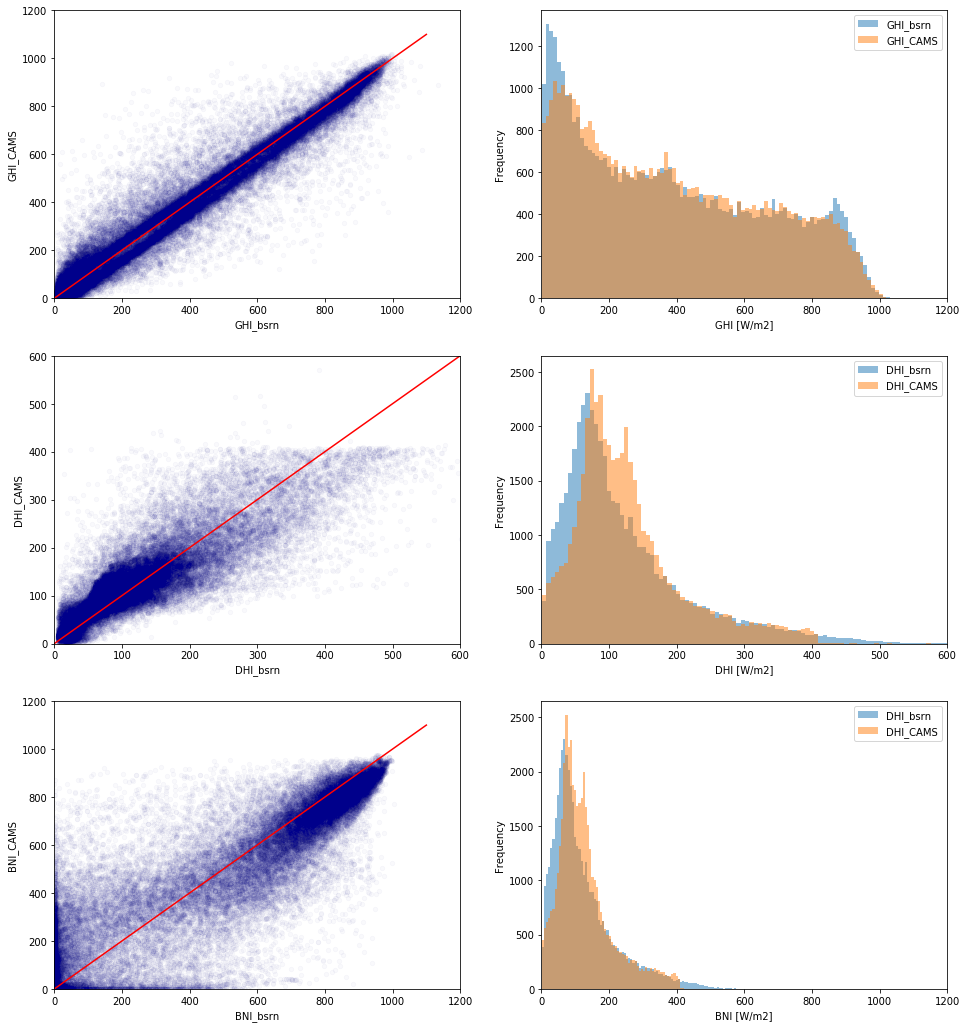

In [282]:
fig, axs = plt.subplots(3,2,figsize=(16,18))

g00=SolarDF_15min[index].plot.scatter(x="GHI_bsrn",y="GHI_CAMS",c='DarkBlue',alpha=0.025,ax=axs[0,0])
g00.plot([0,1100],[0,1100],color='r')
axs[0,0].set_xlim(0,1200)
axs[0,0].set_ylim(0,1200)

g10=SolarDF_15min[index].plot.scatter(x="DHI_bsrn",y="DHI_CAMS",c='DarkBlue',alpha=0.025,ax=axs[1,0])
g10.plot([0,600],[0,600],color='r')

axs[1,0].set_xlim(0,600)
axs[1,0].set_ylim(0,600)

g20=SolarDF_15min[index].plot.scatter(x="BNI_bsrn",y="BNI_CAMS",c='DarkBlue',alpha=0.025,ax=axs[2,0])
g20.plot([0,1100],[0,1100],color='r')
axs[2,0].set_xlim(0,1200)
axs[2,0].set_ylim(0,1200)

g01=SolarDF_15min[["GHI_bsrn","GHI_CAMS"]][index].plot.hist(bins=100, alpha=0.5,ax=axs[0,1])
axs[0,1].set_xlim(0,1200)
axs[0,1].set_xlabel("GHI [W/m2]")
g11=SolarDF_15min[["DHI_bsrn","DHI_CAMS"]][index].plot.hist(bins=100, alpha=0.5,ax=axs[1,1])
axs[1,1].set_xlim(0,600)
axs[1,1].set_xlabel("DHI [W/m2]")
g21=SolarDF_15min[["DHI_bsrn","DHI_CAMS"]][index].plot.hist(bins=100, alpha=0.5,ax=axs[2,1])
axs[2,1].set_xlim(0,1200)
axs[2,1].set_xlabel("BNI [W/m2]")


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


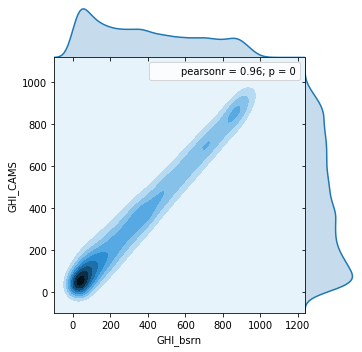

In [240]:
import seaborn as sns
import matplotlib.gridspec as gridspec
import scipy.stats as stats


pr = lambda a, b: np.corrcoef(a, b)[0,1]

#f, axes = plt.subplots(1, 3)
j=sns.jointplot(data=SolarDF_15min[index], x='GHI_bsrn', y='GHI_CAMS',kind='kde', height=5, space=0,\
              n_levels=10).annotate(stats.pearsonr)
#sns.jointplot(data=SolarDF_15min[index], x='DHI_bsrn', y='DHI_CAMS',kind='kde', height=5, space=0, ax=axes[1])
#sns.jointplot(data=SolarDF_15min[index], x='BNI_bsrn', y='BNI_CAMS',kind='kde', height=5, space=0, ax=axes[2])

#plt.show()



#g = sns.jointplot(cctp,octp, kind="kde",size=8,space=0.2,cbar=True,
#        n_levels=50,cbar_kws={"format": formatter, "label": 'My colorbar'},
#        stat_func=pr, annot_kws={'stat':'pearsonr'})

In [219]:
g = sns.PairGrid(data=SolarDF_15min[index], x=['GHI_bsrn','DHI_bsrn'], y=['GHI_CAMS','DHI_CAMS'], height=4)
g.map(sns.jointplot, color=".3")

TypeError: __init__() got an unexpected keyword argument 'x'

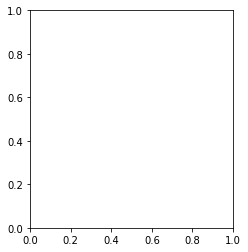

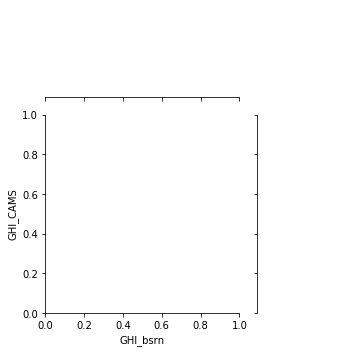

In [228]:
import seaborn as sns
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8,4))
gs = gridspec.GridSpec(1,2, wspace=.2)

fig.add_subplot(gs[0])
g = sns.JointGrid(x="GHI_bsrn", y="GHI_CAMS", data=SolarDF_15min[index], height=5, ratio=2)
#g = g.plot_joint(sns.kdeplot, cmap="Reds_d")
#g = g.plot_marginals(sns.kdeplot, color="r", shade=True)
plt.show()